# Developing an AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

First up is importing the packages you'll need. It's good practice to keep all the imports at the beginning of your code. As you work through this notebook and find you need to import a package, make sure to add the import up here.

In [2]:
# Imports here
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models

import json

from PIL import Image
import numpy as np

import pandas as pd
import seaborn as sb

## Load the data

Here you'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). The data should be included alongside this notebook, otherwise you can [download it here](https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz). The dataset is split into three parts, training, validation, and testing. For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. You'll also need to make sure the input data is resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

The pre-trained networks you'll use were trained on the ImageNet dataset where each color channel was normalized separately. For all three sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.
 

In [3]:
def transform_train_data(data_dir, batch_size):
    '''
    Transforms flower images into pytorch tensors to be used for training 
    and validation
    
    arguments:
        data_dir: directory of the flower images
        batch_size: quantity of images to be loaded at a time
        
    return:
        train_image_datasets: imagefolder of training images
        train_dataloaders: image tensors of training data
        validation_dataloaders: image tensor of validation data
        
    Code Attribution:
        This function contains code that was updated and leveraged from the 
        Udacity AI Programming with Python Nano Degree Training material.
    '''
    
    train_dir = data_dir + '/train'
    valid_dir = data_dir + '/valid'

    # adding noise into the training dataset to help model to better generalize
    train_transforms = transforms.Compose([transforms.RandomResizedCrop(224),
                                          transforms.RandomVerticalFlip(),
                                          transforms.RandomRotation(30),
                                          transforms.ToTensor(),
                                          transforms.Normalize([0.485, 0.456, 0.406], 
                                                               [0.229, 0.224, 0.225])])
    
    validation_transforms = transforms.Compose([transforms.Resize(224), 
                                                transforms.CenterCrop(224), 
                                                transforms.ToTensor(), 
                                                transforms.Normalize([0.485, 0.456, 0.406], 
                                                                     [0.229, 0.224, 0.225])])
    
    # Load the datasets with ImageFolder
    train_image_datasets = datasets.ImageFolder(train_dir, transform=train_transforms)
    validation_image_datasets = datasets.ImageFolder(valid_dir, transform=validation_transforms)
    
    # Using the image datasets and the trainforms, define the dataloaders
    train_dataloaders = torch.utils.data.DataLoader(train_image_datasets, batch_size=batch_size, shuffle=True)
    validation_dataloaders = torch.utils.data.DataLoader(validation_image_datasets, batch_size=batch_size)
    
    return train_image_datasets, train_dataloaders, validation_dataloaders

def transform_test_data(data_dir, batch_size):
    '''
    Transforms flower images into pytorch tensors to be used for testing
    
    arguments:
        data_dir: directory of the flower images
        batch_size: quantity of images to be loaded at a time
    
    return:
        test_dataloaders: image tensors of testing data
        
    Code Attribution:
        This function contains code that was updated and leveraged from the 
        Udacity AI Programming with Python Nano Degree Training material.
    '''
    
    test_dir = data_dir + '/test'

    test_transforms = transforms.Compose([transforms.Resize(224), 
                                          transforms.CenterCrop(224), 
                                          transforms.ToTensor(), 
                                          transforms.Normalize([0.485, 0.456, 0.406], 
                                                               [0.229, 0.224, 0.225])])
    
    # Load the datasets with ImageFolder
    test_image_datasets = datasets.ImageFolder(test_dir, transform=test_transforms)
    
    # Using the image datasets and the trainforms, define the dataloaders
    test_dataloaders = torch.utils.data.DataLoader(test_image_datasets, batch_size=batch_size)
    
    return test_dataloaders

In [4]:
data_dir = 'flowers'
batch_size = 32

train_image_datasets, train_dataloaders, validation_dataloaders = transform_train_data(data_dir, batch_size)
test_dataloaders = transform_test_data(data_dir, batch_size)

### Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [5]:
with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

In [6]:
print(list(cat_to_name.items())[:5])

[('21', 'fire lily'), ('3', 'canterbury bells'), ('45', 'bolero deep blue'), ('1', 'pink primrose'), ('34', 'mexican aster')]


# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, you should use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. Refer to [the rubric](https://review.udacity.com/#!/rubrics/1663/view) for guidance on successfully completing this section. Things you'll need to do:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) (If you need a starting point, the VGG networks work great and are straightforward to use)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right. Make sure to try different hyperparameters (learning rate, units in the classifier, epochs, etc) to find the best model. Save those hyperparameters to use as default values in the next part of the project.

One last important tip if you're using the workspace to run your code: To avoid having your workspace disconnect during the long-running tasks in this notebook, please read in the earlier page in this lesson called Intro to
GPU Workspaces about Keeping Your Session Active. You'll want to include code from the workspace_utils.py module.

**Note for Workspace users:** If your network is over 1 GB when saved as a checkpoint, there might be issues with saving backups in your workspace. Typically this happens with wide dense layers after the convolutional layers. If your saved checkpoint is larger than 1 GB (you can open a terminal and check with `ls -lh`), you should reduce the size of your hidden layers and train again.

The output of this VGG13 model's features is 25,088.  Our classifier needs an input of 25088.

In [7]:
# TODO: Build and train your network

# load our feature detector model
model = models.vgg13(pretrained=True)
model

Downloading: "https://download.pytorch.org/models/vgg13-c768596a.pth" to /root/.torch/models/vgg13-c768596a.pth
100%|██████████| 532194478/532194478 [00:25<00:00, 20761786.83it/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (16): ReLU(inplace)
    (17): Conv2d

In [8]:
# freeze the VGG parameters
for param in model.parameters():
    param.requires_grad = False
    
class Classifier(nn.Module):
    def __init__(self, input_size, output_size, hidden_layers, drop_p=.2):
        super().__init__()
        
        self.input_size = input_size
        self.output_size = output_size
        
        # first layer input
        self.hidden_layers = nn.ModuleList([nn.Linear(input_size, hidden_layers[0])])
        
        # creates a tuple of passed in hidden_layer 
        # create a list of linear layers with passed in tuple values
        # list of linear layers to to the classifier's hidden layers
        h_linear_list = []
        h_tuples = zip(hidden_layers[:-1], hidden_layers[1:])
        h_linear_list = [nn.Linear(h1, h2) for h1, h2 in h_tuples]
        self.hidden_layers.extend(h_linear_list)
        
        self.output = nn.Linear(hidden_layers[-1], output_size)
        
        self.dropout = nn.Dropout(p=drop_p)
        
    def forward(self, x):
        '''
        Image classifier forward loop method
        
        arguments:
            x: image tensors that will get processed through the forward pass
        
        return:
            x: image tensor after completing the forword pass
        
        Code Attribution:
            This function contains code that was updated and leveraged from the 
            Udacity AI Programming with Python Nano Degree Training material.
        '''
        
        x = x.view(x.shape[0], -1)
        
        for h in self.hidden_layers:
            x = F.relu(h(x))
            x = self.dropout(x)
        x = self.output(x)
        x = F.log_softmax(x, dim=1)
        
        return x

Lets view our updated network architecture with updated classifier.

In [9]:
model.classifier = Classifier(25088, 102, [500], drop_p=.2)
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (16): ReLU(inplace)
    (17): Conv2d

Now lets train and validate our VGG classification model.

In [10]:
def train_model(model, criterion, optimizer, train_dataloaders, 
                validation_dataloaders, device, epochs=3, print_every=40):
    '''
    Trains a model's image classifier parameters against a provided train 
    and validation image directories and freezes the feature parameters per 
    provided functional parameters
    
    arguments:
        model: image classifier model
        criterion: loss function
        optimizer: gradient descent optimizer
        train_dataloaders: training image tensors
        validation_dataloaders: validation image tensors
        device: cpu or gpu
        epochs: quantity of epoch iteration to train model
        print_every: quantity of training steps until training info is displayed
        
    Code Attribution:
        This function contains code that was updated and leveraged from the 
        Udacity AI Programming with Python Nano Degree Training material.
    '''
    
    model = model.to(device)

    for e in range(epochs):

        running_loss = 0
        # track steps so that model training status can be displayed per print_every param
        steps = 0
        model.train()
        for images, labels in train_dataloaders:

            steps += 1

            # pass images and labels tensors to the GPU if available
            images, labels = images.to(device), labels.to(device)

            # zerize graddient after each batch
            optimizer.zero_grad()

            # forward pass and calculate loss
            log_ps = model.forward(images)
            loss = criterion(log_ps, labels)

            # backward pass and calculate gradient steps
            loss.backward()
            optimizer.step()

            # calculate running across the batch of images
            running_loss += loss.item()

            # print model parameters periodically
            if steps % print_every == 0:

                validation_loss = 0
                accuracy = 0

                # turn of gradient
                with torch.no_grad():
                    # model validation
                    model.eval()

                    for images, labels in validation_dataloaders:

                        # pass images and labels tensors to the GPU if available
                        images, labels = images.to(device), labels.to(device)

                        # forward pass and calculate test loss
                        log_ps = model.forward(images)
                        validation_loss += criterion(log_ps, labels).item()

                        ps = torch.exp(log_ps)
                        top_p, top_class = ps.topk(1, dim=1)
                        equals = top_class == labels.view(*top_class.shape)
                        accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

                    print("Epoch: {}/{}.. ".format(e+1, epochs), 
                          "Training Loss: {:.3f}.. ".format(running_loss/print_every),
                          "Validation Loss: {:.3f}.. ".format(validation_loss/len(validation_dataloaders)),
                          "Accuracy: {:.3f}..".format(accuracy/len(validation_dataloaders)))

                    running_loss = 0
                    # resume model training
                    model.train()

In [10]:
epochs = 5
print_every = 40
learn_rate = .00085

# define the criterion and optimizer
# only optimize the classifier parameters, freeze feature parameters
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=learn_rate)

# if gpu is available use it
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")    

train_model(model, criterion, optimizer, train_dataloaders, validation_dataloaders, device, epochs, print_every)

Epoch: 1/5..  Training Loss: 4.193..  Validation Loss: 3.148..  Accuracy: 0.327..
Epoch: 1/5..  Training Loss: 3.147..  Validation Loss: 2.239..  Accuracy: 0.441..
Epoch: 1/5..  Training Loss: 2.521..  Validation Loss: 1.641..  Accuracy: 0.579..
Epoch: 1/5..  Training Loss: 2.211..  Validation Loss: 1.396..  Accuracy: 0.615..
Epoch: 1/5..  Training Loss: 2.025..  Validation Loss: 1.366..  Accuracy: 0.644..
Epoch: 2/5..  Training Loss: 1.699..  Validation Loss: 1.175..  Accuracy: 0.663..
Epoch: 2/5..  Training Loss: 1.660..  Validation Loss: 1.048..  Accuracy: 0.726..
Epoch: 2/5..  Training Loss: 1.642..  Validation Loss: 0.983..  Accuracy: 0.738..
Epoch: 2/5..  Training Loss: 1.612..  Validation Loss: 1.064..  Accuracy: 0.701..
Epoch: 2/5..  Training Loss: 1.518..  Validation Loss: 0.904..  Accuracy: 0.756..
Epoch: 3/5..  Training Loss: 1.486..  Validation Loss: 0.801..  Accuracy: 0.776..
Epoch: 3/5..  Training Loss: 1.451..  Validation Loss: 0.809..  Accuracy: 0.788..
Epoch: 3/5..  Tr

## Testing your network

It's good practice to test your trained network on test data, images the network has never seen either in training or validation. This will give you a good estimate for the model's performance on completely new images. Run the test images through the network and measure the accuracy, the same way you did validation. You should be able to reach around 70% accuracy on the test set if the model has been trained well.

In [11]:
def test_model(model, criterion, test_dataloaders, device):
    '''
    Tests a model's image classifier against a directory of test images.
    Prints out Test Loss and Accuracy status
    
    arguments:
        model: image classifier model
        criterion: loss function
        test_dataloaders: test image tensors
        device: cpu or gpu
    
    Code Attribution:
        This function contains code that was updated and leveraged from the 
        Udacity AI Programming with Python Nano Degree Training material.
    '''
    
    with torch.no_grad():

        test_loss = 0
        accuracy = 0
        # model validation
        model.eval()

        for images, labels in test_dataloaders:

            images, labels = images.to(device), labels.to(device)

            # forward pass and calculate test loss
            log_ps = model.forward(images)
            test_loss += criterion(log_ps, labels).item()

            ps = torch.exp(log_ps)
            top_p, top_class = ps.topk(1, dim=1)
            equals = top_class == labels.view(*top_class.shape)
            accuracy += torch.mean(equals.type(torch.FloatTensor))

        print("Test Loss: {:.3f}.. ".format(test_loss/len(test_dataloaders)),
              "Accuracy: {:.3f}..".format(accuracy/len(test_dataloaders)))

In [12]:
test_model(model, criterion, test_dataloaders, device)

Test Loss: 0.789..  Accuracy: 0.790..


## Save the checkpoint

Now that your network is trained, save the model so you can load it later for making predictions. You probably want to save other things such as the mapping of classes to indices which you get from one of the image datasets: `image_datasets['train'].class_to_idx`. You can attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

Remember that you'll want to completely rebuild the model later so you can use it for inference. Make sure to include any information you need in the checkpoint. If you want to load the model and keep training, you'll want to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. You'll likely want to use this trained model in the next part of the project, so best to save it now.

In [12]:
# get the training dataset's dictionary of classes mapped to indices
class_to_idx = train_image_datasets.class_to_idx

# switch dictionary key value and assign to model.class_to_idx
model.class_to_idx = {class_to_idx[i]: i for i in class_to_idx}

# view first five indices
print(list(model.class_to_idx.items())[:5])

[(0, '1'), (1, '10'), (2, '100'), (3, '101'), (4, '102')]


In [13]:
# TODO: Save the checkpoint 
def save_checkout(save_dir, input_size, output_size, hidden_layers, dropout, state_dict, 
                  epochs, optimizer_state, class_to_idx, learn_rate, batch_size):
    '''
    Saves the trained flower image classifier as checkpoint file
    
    arguments:
        save_dir: directory where checkpoint will be saved
        input_size: input size of the model classifer
        out_size: output size of the model classifer
        hidden_layers: hidden layer dimensions of the model classifier
        dropout: percent of the model classifier nodes that do not train in 
        a training step to prevent overfitting
        state_dict: weights of the trained hidden layers
        epochs: quantity of epochs the model performs
        optimizer_state: gradient step state
        class_to_idx: mapping of flower class to index
        learn_rate: gradient step rate
        batch_size: quantity of images to be loaded during training
    
    Code Attribution:
        This function contains code that was updated and leveraged from the 
        Udacity AI Programming with Python Nano Degree Training material.
    '''
    
    checkpoint = {'input_size': input_size,
              'output_size': output_size,
              'hidden_layers': hidden_layers,
              'dropout': dropout,
              'state_dict': state_dict,
              'epoch': epochs,
              'optimizer_state': optimizer_state,
              'model_class_to_idx': class_to_idx,
              'learning_rate': learn_rate,
              'batch_size': batch_size}

    torch.save(checkpoint, save_dir + "/checkpoint_part.pth")

In [15]:
save_checkout("SavedModels", model.classifier.input_size, model.classifier.output_size, 
              [each.out_features for each in model.classifier.hidden_layers], 
              model.classifier.dropout.p, model.state_dict(), epochs, 
              optimizer.state_dict(), 
              model.class_to_idx, learn_rate, batch_size)

## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way you can come back to this project and keep working on it without having to retrain the network.

In [14]:
# TODO: Write a function that loads a checkpoint and rebuilds the model
def load_checkpoint(filepath, model):
    '''
    Loads the trained flower image classifier checkpoint
    
    arguments:
        filepath: the file path of the trained flower image classifier 
        checkpoint
        model: model object that will be loaded with the trained flower image 
        classifier
        
    return:
        model: model object loaded with the trained flower image classifier
        model_class_to_idx: mapping of flower class to index
        
    Code Attribution:
        This function contains code that was updated and leveraged from the 
        Udacity AI Programming with Python Nano Degree Training material.
    '''
    
    checkpoint = torch.load(filepath)
    model.classifier = Classifier(checkpoint["input_size"], 
                                  checkpoint["output_size"], 
                                  checkpoint["hidden_layers"], 
                                  checkpoint["dropout"])
    model.load_state_dict(checkpoint['state_dict'])
    model_class_to_idx = checkpoint["model_class_to_idx"]
    
    return model, model_class_to_idx

# Inference for classification

Now you'll write a function to use a trained network for inference. That is, you'll pass an image into the network and predict the class of the flower in the image. Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like 

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First you'll need to handle processing the input image such that it can be used in your network. 

## Image Preprocessing

You'll want to use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then you'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. You'll need to convert the values. It's easiest with a Numpy array, which you can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. You'll want to subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. You can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

In [15]:
def process_image(image):
    ''' 
    Scales, crops, and normalizes a PIL image for a PyTorch model,
    
    argument:
        image: flower image to predict classification
    
    returns:
        image: flower image Numpy array
        
    Code Attribution:
        This function contains code that was updated and leveraged from the 
        Udacity AI Programming with Python Nano Degree Training material.
    '''
    image_file = Image.open(image)
    image_file = image_file.resize((256, 256))
    
    width, height = image_file.size
    left = (width - 224) / 2
    top = (height - 224) / 2
    right = (width + 224) / 2
    bottom = (height + 224) / 2
    image_file = image_file.crop((left, top, right, bottom))
    
    # read image in as numpy array and normalize
    np_image = np.array(image_file) / 256
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    np_image = (np_image - mean) / std
    
    # color channel moved from 3rd to 1st dimension
    np_image = np_image.transpose((2,0,1))
    image = torch.from_numpy(np_image)
    
    return image

To check your work, the function below converts a PyTorch tensor and displays it in the notebook. If your `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

In [16]:
def imshow(image, ax=None, title=None):
    """
    Imshow for Tensor.
    
    Code Attribution:
        This is Udacity code.  No changes made to this function.
    """
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy().transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

The below training image tests the process_image function.

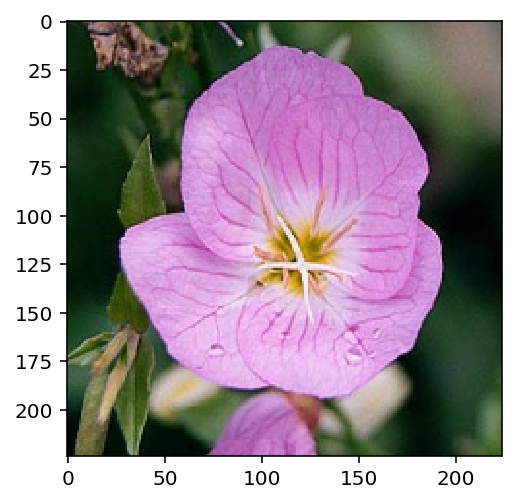

In [17]:
image_file = data_dir + "/train/1/image_06734.jpg"
image = process_image(image_file)
imshow(image)

## Class Prediction

Once you can get images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. You'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. You need to convert from these indices to the actual class labels using `class_to_idx` which hopefully you added to the model or from an `ImageFolder` you used to load the data ([see here](#Save-the-checkpoint)). Make sure to invert the dictionary so you get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [18]:
def predict(image_path, device, model, topk=5):
    ''' 
    Predict the class (or classes) of an image using a trained deep 
    learning model.
    
    argument:
        image_path: flower image to predict classification
        device: cpu or gpu
        model: model object loaded with the trained flower image classifier
        topk: return the top k probable classes and probabilities
    
    returns:
        top_p: top k probable probabilities
        top_class: top k probable classes
        
    Code Attribution:
        This function contains code that was updated and leveraged from the 
        Udacity AI Programming with Python Nano Degree Training material.
    '''
    model = model.to(device)

    model.eval()

    # convert numpy processed flower image into the torch tensor
    image = process_image(image_path)
    image_tensor = image.type(torch.cuda.FloatTensor)
    image_tensor = image_tensor.unsqueeze(dim=0)

    # turn off gradient descent
    with torch.no_grad():
    
        image_tensor.to(device)
    
        # forward pass and calculate loss
        log_ps = model.forward(image_tensor)

        # convert log loss with exponential and return probilities
        ps = torch.exp(log_ps)
        top_p, top_class = ps.topk(topk, dim=1)
        
        top_p = top_p.to("cpu").numpy()
        top_class = top_class.to("cpu").numpy()
    
    return top_p, top_class

## Sanity Checking

Now that you can use a trained model for predictions, check to make sure it makes sense. Even if the testing accuracy is high, it's always good to check that there aren't obvious bugs. Use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:

<img src='assets/inference_example.png' width=300px>

You can convert from the class integer encoding to actual flower names with the `cat_to_name.json` file (should have been loaded earlier in the notebook). To show a PyTorch tensor as an image, use the `imshow` function defined above.

In [19]:
def align_class_prob(cat_to_name_file, model_class_to_idx, classes, probs):
    '''
    Align the most probable flower classes and corresponding probabilities
    
    arguments:
        cat_to_name_file: flower category name to index translation
        model_class_to_idx: mapping of flower class to index
        classes: most probable flower class categories
        probs: most probable flow class probabilities
    
    returns:
        panda dataframe of most probable flower classes and correpsonding 
        probabilities
    '''
    
    with open(cat_to_name_file, 'r') as f:
        cat_to_name = json.load(f)
    
    class_names = []
    for class_index in classes[0]:
        class_names.append(cat_to_name[model_class_to_idx[class_index]])
    
    df = pd.DataFrame(
        {"class_name" : class_names,
        "prob" : probs[0]})
    
    return df

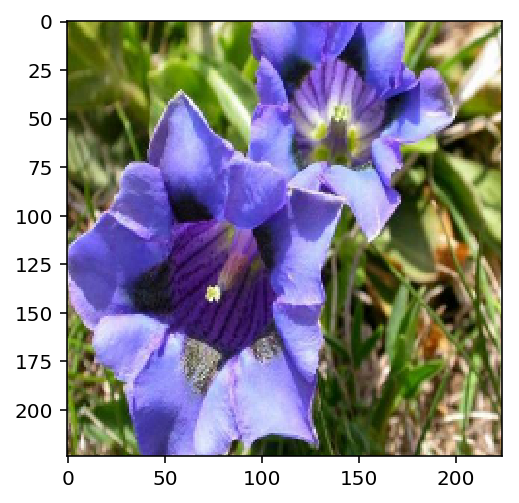

In [20]:
# TODO: Display an image along with the top 5 classes
image_path = data_dir + "/test/28/image_05230.jpg"
imshow(process_image(image_path))
model, model_class_to_idx = load_checkpoint("SavedModels/checkpoint.pth", model)

# if gpu is available use it
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")    
probs, classes = predict(image_path, device, model, 5)

In [21]:
df = align_class_prob("cat_to_name.json", model_class_to_idx, classes, probs)
print(df)

         class_name      prob
0  stemless gentian  0.722565
1  canterbury bells  0.098519
2         monkshood  0.043331
3         sweet pea  0.036909
4      garden phlox  0.021493


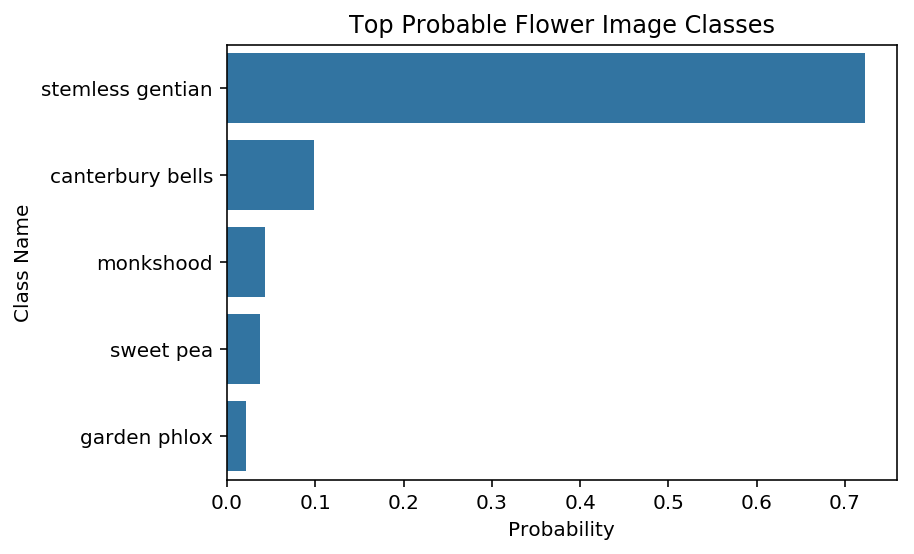

In [22]:
color_type = sb.color_palette()[0]
df_sorted = df.sort_values("prob", ascending=False)
sb.barplot(data=df_sorted, y="class_name", x="prob", color=color_type)
plt.title("Top Probable Flower Image Classes")
plt.xlabel("Probability")
plt.ylabel("Class Name")
plt.show();